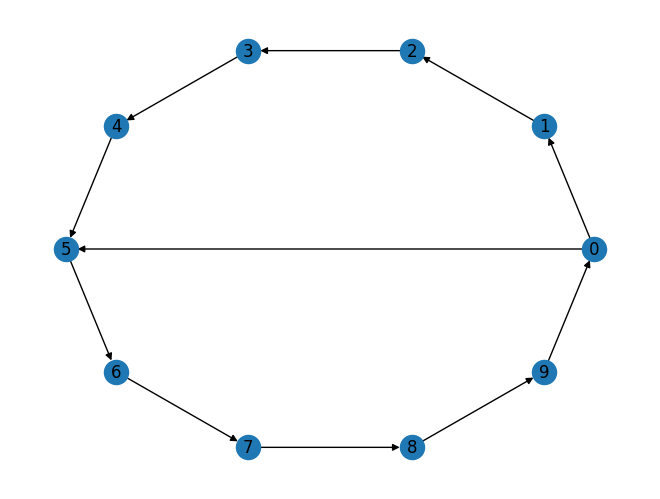

In [1]:
import networkx as nx

g: nx.DiGraph = nx.cycle_graph(10, nx.DiGraph)
g.add_edge(0, 5)
nx.draw(g, pos=nx.circular_layout(g), with_labels=True)
a = nx.community.louvain_communities(g)
#for i in g.nodes:
#    print(f"[{i}]:", comm[i])



In [ ]:
import matplotlib.pyplot as plt
import random
print(f"検出されたコミュニティ数: {len(a)}")
for i, comm in enumerate(a):
    subG = g.subgraph(comm)  # コミュニティ部分グラフ
    pos = nx.spring_layout(subG, seed=42)

    # ノード・エッジの色（見やすいよう同系色系統で統一）
    color = plt.cm.tab20(i % 20)  # 20色パレット
    edge_colors = [color for _ in subG.edges]

    plt.figure(figsize=(6, 6))

    # エッジを先に描画（ノードの下地）
    nx.draw_networkx_edges(
        subG,
        pos,
        edge_color=edge_colors,
        alpha=0.5,
        width=1.0
    )

    # ノードを上に重ねる
    nx.draw_networkx_nodes(
        subG,
        pos,
        node_color=color,
        node_size=50
    )

    plt.title(f"Community {i} (size={len(comm)})")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

#描画で見る限り有向グラフだった

In [4]:
twitter: nx.DiGraph = nx.read_edgelist("./ego-Twitter/twitter_combined.txt.gz", create_using=nx.DiGraph)
twitter.number_of_nodes(), twitter.number_of_edges(), twitter.is_directed()

(81306, 1768149, True)

In [5]:
#サンプリングしたグラフからコミュニティ検出（louvain法）
import networkx as nx

twitter: nx.DiGraph = nx.read_edgelist("sampled_twitter_graph.txt", create_using=nx.DiGraph)

twitter.number_of_nodes(), twitter.number_of_edges(), twitter.is_directed()

twitter_comms = nx.community.louvain_communities(twitter)

print(f"検出されたコミュニティ数: {len(twitter_comms)}")

検出されたコミュニティ数: 49


In [7]:
#検出したコミュニティの保存
import os
import json
import numpy as np
# --- 2. 保存用フォルダの作成 ---
output_folder = "communities_txt_dict"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"\n保存用フォルダ '{output_folder}' を作成しました。")
else:
    print(f"\n保存用フォルダ '{output_folder}' は既に存在します。")


# --- 3. 各コミュニティを個別のJSONファイルとして保存 ---
print("各コミュニティをサブグラフとして抽出し、txtファイルに保存しています...")

# enumerateを使い、コミュニティのインデックス番号をファイル名に利用する
for i, community_nodes in enumerate(twitter_comms):
    if len(community_nodes) < 2:
        continue
    
    # Step 3-1: サブグラフを生成
    subgraph = twitter.subgraph(community_nodes)
    
    # Step 3-2: サブグラフから隣接行列を生成
    node_list = list(subgraph.nodes())
    adj_matrix_np = nx.to_numpy_array(subgraph, nodelist=node_list, dtype=int)
    
    # Step 3-3: NumPy配列を辞書形式に変換
    adjacency_dict = {}
    for row_idx, source_node in enumerate(node_list):
        row_dict = {}
        for col_idx, target_node in enumerate(node_list):
            row_dict[target_node] = int(adj_matrix_np[row_idx, col_idx])
        
        adjacency_dict[source_node] = row_dict
        
    # Step 3-4: ファイルパスを定義 (★変更点1: 拡張子を.txtに変更)
    file_path = os.path.join(output_folder, f"community_{i}.txt")
    
    # Step 3-5: TXTファイルとして書き出す (★変更点2: json.dumpからf.writeに変更)
    with open(file_path, 'w', encoding='utf-8') as f:
        # 辞書をstr()で文字列に変換して書き込む
        f.write(str(adjacency_dict))

print(f"\n処理完了: {len(twitter_comms)}個のコミュニティを '{output_folder}' フォルダにTXTファイルとして保存しました。")


保存用フォルダ 'communities_txt_dict' は既に存在します。
各コミュニティをサブグラフとして抽出し、txtファイルに保存しています...

処理完了: 49個のコミュニティを 'communities_txt_dict' フォルダにTXTファイルとして保存しました。


In [6]:
import os
import json # JSONを保存するために必要
import numpy as np
# (networkx as nx, twitter, twitter_comms が定義済みであると仮定します)

# --- 2. 保存用フォルダの作成 (TXT用) ---
output_folder_txt = "communities_txt_dict2"
if not os.path.exists(output_folder_txt):
    os.makedirs(output_folder_txt)
    print(f"\n保存用フォルダ '{output_folder_txt}' を作成しました。")
else:
    print(f"\n保存用フォルダ '{output_folder_txt}' は既に存在します。")

# --- ★★★ 追加: JSON用の保存フォルダを作成 ★★★ ---
output_folder_json = "communities_json_matrix"
if not os.path.exists(output_folder_json):
    os.makedirs(output_folder_json)
    print(f"保存用フォルダ '{output_folder_json}' を作成しました。")
else:
    print(f"保存用フォルダ '{output_folder_json}' は既に存在します。")


# --- 3. 各コミュニティをサブグラフとして抽出し、ファイルに保存 ---
print("\n各コミュニティをサブグラフとして抽出し、txtとjsonファイルに保存しています...")

# enumerateを使い、コミュニティのインデックス番号をファイル名に利用する
for i, community_nodes in enumerate(twitter_comms):
    if len(community_nodes) < 2:
        continue
    
    # Step 3-1: サブグラフを生成
    subgraph = twitter.subgraph(community_nodes)
    
    # Step 3-2: サブグラフから隣接行列を生成
    node_list = list(subgraph.nodes())
    adj_matrix_np = nx.to_numpy_array(subgraph, nodelist=node_list, dtype=int)
    
    # Step 3-3: NumPy配列を辞書形式に変換 (int型にキャスト済み)
    adjacency_dict = {}
    for row_idx, source_node in enumerate(node_list):
        row_dict = {}
        for col_idx, target_node in enumerate(node_list):
            # このint()により、データはJSONが扱えるPythonのint型になります
            row_dict[target_node] = int(adj_matrix_np[row_idx, col_idx])
        
        adjacency_dict[source_node] = row_dict
        
    # Step 3-4: TXTファイルとして書き出す
    file_path_txt = os.path.join(output_folder_txt, f"community_{i}.txt")
    with open(file_path_txt, 'w', encoding='utf-8') as f:
        f.write(str(adjacency_dict))
        
    # --- ★★★ 追加: JSONファイルとして書き出す ★★★ ---
    # Step 3-5: JSONファイルとして書き出す
    file_path_json = os.path.join(output_folder_json, f"community_{i}.json")
    with open(file_path_json, 'w', encoding='utf-8') as f:
        # json.dumpで辞書をJSON形式で保存
        # indent=Noneで改行なしのコンパクトな形式
        json.dump(adjacency_dict, f, indent=None)

print(f"\n処理完了: {len(twitter_comms)}個のコミュニティを '{output_folder_txt}' (TXT) および '{output_folder_json}' (JSON) フォルダに保存しました。")


保存用フォルダ 'communities_txt_dict2' は既に存在します。
保存用フォルダ 'communities_json_matrix' は既に存在します。

各コミュニティをサブグラフとして抽出し、txtとjsonファイルに保存しています...

処理完了: 49個のコミュニティを 'communities_txt_dict2' (TXT) および 'communities_json_matrix' (JSON) フォルダに保存しました。


In [1]:
import networkx as nx
import os
import ast  # jsonの代わりにastをインポート

# コミュニティファイルが保存されているフォルダ名
# (TXTファイルを保存したフォルダ名に変更してください)
folder_name = "communities_txt_dict" 

# フォルダの存在確認
if not os.path.exists(folder_name):
    print(f"エラー: フォルダ '{folder_name}' が見つかりません。")
    exit()

# 各コミュニティの情報を格納するためのリスト
community_stats = []

print(f"フォルダ '{folder_name}' 内のコミュニティを読み込み、密度を計算します...\n")

# フォルダ内の全TXTファイルを取得 (json -> txt)
try:
    txt_files = [f for f in os.listdir(folder_name) if f.endswith('.txt')]
    if not txt_files:
        print("エラー: フォルダ内にTXTファイルが見つかりません。")
        exit()
except Exception as e:
    print(f"エラー: フォルダの読み込み中に問題が発生しました。 {e}")
    exit()

# --- 1. 各コミュニティの密度を計算 ---
for filename in txt_files:
    file_path = os.path.join(folder_name, filename)
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            # ★★★ 変更点1 ★★★
            # ファイル全体を文字列として読み込む
            dict_string = f.read()
            
            # ast.literal_evalで文字列を安全に辞書に変換
            adj_dict = ast.literal_eval(dict_string)
            
            # ★★★ 変更点2 ★★★
            # 辞書（隣接行列）から有向グラフを復元
            subgraph = nx.from_dict_of_dicts(adj_dict, create_using=nx.DiGraph)
            
            # ノード数が2未満のグラフでは密度が計算できないためスキップ
            if subgraph.number_of_nodes() < 2:
                continue
                
            # グラフの密度を計算
            # nx.density()はグラフが有向か無向かを自動で判別します
            density = nx.density(subgraph)
            
            # 結果をリストに追加
            community_stats.append({
                "filename": filename,
                "nodes": subgraph.number_of_nodes(),
                "edges": subgraph.number_of_edges(),
                "density": density
            })
    except Exception as e:
        print(f"エラー: ファイル '{filename}' の処理中に問題が発生しました。 {e}")
        continue # 問題のあったファイルはスキップ

# --- 2. 密度に基づいてコミュニティをソート ---
if not community_stats:
    print("密度を計算できるコミュニティが見つかりませんでした。")
    exit()

# densityキーの値を基準に、リストを昇順にソート
sorted_communities = sorted(community_stats, key=lambda x: x["density"])


# --- 3. 最小、最大、中間のコミュニティを特定 ---
lowest_density_comm = sorted_communities[0]
highest_density_comm = sorted_communities[-1]
median_index = len(sorted_communities) // 2
median_density_comm = sorted_communities[median_index]


# --- 4. 結果を表示 ---
print("--- 分析結果 ---")

def print_community_info(title, community_info):
    """コミュニティの情報をきれいに表示する関数"""
    print(f"\n◆ {title}")
    print(f"  ファイル名: {community_info['filename']}")
    print(f"  ノード数  : {community_info['nodes']}")
    print(f"  エッジ数  : {community_info['edges']}")
    print(f"  密度      : {community_info['density']:.6f}")

print_community_info("最も密度が低いコミュニティ (最も疎)", lowest_density_comm)
print_community_info("密度が中間値のコミュニティ", median_density_comm)
print_community_info("最も密度が高いコミュニティ (最も密)", highest_density_comm)

フォルダ 'communities_txt_dict' 内のコミュニティを読み込み、密度を計算します...

エラー: ファイル 'community_1.txt' の処理中に問題が発生しました。 'int' object is not iterable
エラー: ファイル 'community_0.txt' の処理中に問題が発生しました。 'int' object is not iterable
エラー: ファイル 'community_2.txt' の処理中に問題が発生しました。 'int' object is not iterable
エラー: ファイル 'community_3.txt' の処理中に問題が発生しました。 'int' object is not iterable


KeyboardInterrupt: 

In [9]:
#コミュニティが有向グラフか
import os
import networkx as nx
import ast # 文字列をPythonオブジェクトに安全に変換するためのライブラリ

def validate(adj_dict: dict):
    # データが空、または小さすぎる場合はスキップ
    if not adj_dict or len(adj_dict) < 2:
        print("  => ⚠️ スキップ: コミュニティが空か、ノードが1つのため検証対象外です。")
        # print("-" * 35)
        return
        
    # Step 3: 辞書から有向グラフを復元
    subgraph = nx.from_dict_of_dicts(adj_dict, create_using=nx.DiGraph)

    # 検証A: is_directed() メソッドで確認
    is_directed = subgraph.is_directed()
    print(f"  1. is_directed() メソッドの結果は？ -> {is_directed}")

    # 検証B: 非対称なエッジを探す
    found_asymmetry = False
    for u, v in subgraph.edges():
        if not subgraph.has_edge(v, u):
            print(f"  2. 発見: 非対称なエッジが存在します。 (例: {u} -> {v})")
            found_asymmetry = True
            break
    
    # 最終判定
    if is_directed and found_asymmetry:
        print("  => ✅ 有向グラフであることが確認できました。")
    elif is_directed:
            print("  => ⚠️ 有向グラフとして扱われていますが、全ての関係が対称的（相互フォロー）です。")
    else:
        print("  => ❌ 有向グラフではありません。")


# コミュニティファイルが保存されているフォルダ名
def load_adj_data(filename: str, folder_name = "communities_txt_dict", ):
    file_path = os.path.join(folder_name, filename)
    
    print(f"ファイル: {filename} の load")
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            # Step 1: ファイルから文字列として読み込む
            return ast.literal_eval(f.read())
    except Exception as e:
        # print(f"  => ❌ エラー: ファイルの処理中に問題が発生しました。")
        # print(f"     エラー内容: {e}")
        return e

In [ ]:
import os

# フォルダの存在確認
if not os.path.exists(folder_name):
    print(f"エラー: フォルダ '{folder_name}' が見つかりません。")
    exit()

print(f"フォルダ '{folder_name}' 内のコミュニティファイルを確認します。\n")

try:
    txt_files = [f for f in os.listdir(folder_name) if f.endswith('.txt')]
    if not txt_files:
        print("エラー: フォルダ内にTXTファイルが見つかりません。")
        exit()
except Exception as e:
    print(f"エラー: フォルダの読み込み中に問題が発生しました。 {e}")
    exit()

# --- 各TXTファイルをループして検証 ---
# print("各TXTファイルを文字列として読み込む")
# file_map: dict[str, str | Exception] = {}
# for filename in txt_files:
    
#     # print("-" * 35)

print("各ファイルの文字列を隣接行列に変換")
adj_dict_map: dict[str, dict | Exception] = {}
for filename in txt_files:
    print(f"--{filename}--")
    buf = load_adj_data(filename)
    if type(buf) == Exception:
        print(f"  => ❌ エラー: ファイルの処理中に問題が発生しました。")
        print(f"     エラー内容: {e}")
        continue
    # Step 2: ast.literal_evalで文字列を辞書に変換
    adj_dict_map[filename] = buf


print("各ファイルの隣接行列を検証")
for filename, adj_dict in adj_dict_map.items():
    print(f"--{filename}--")
    validate(adj_dict)

# # --- 最終結論 ---
# print("\n--- 結論 ---")
# if all_files_valid:
#     print("✅ すべての検証可能なコミュニティファイルが、有向グラフの性質を保持していることを確認できました。")
# else:
#     print("❌ 一部またはすべてのファイルで検証に失敗しました。上記のエラーメッセージを確認してください。")


フォルダ 'communities_txt_dict' 内のコミュニティファイルを確認します。

各TXTファイルを文字列として読み込む
ファイル: community_1.txt の load
ファイル: community_0.txt の load
ファイル: community_2.txt の load
ファイル: community_3.txt の load
ファイル: community_7.txt の load
ファイル: community_6.txt の load
ファイル: community_4.txt の load
ファイル: community_49.txt の load
ファイル: community_48.txt の load
ファイル: community_5.txt の load
ファイル: community_13.txt の load
ファイル: community_12.txt の load
ファイル: community_10.txt の load
ファイル: community_38.txt の load
ファイル: community_39.txt の load
ファイル: community_11.txt の load
ファイル: community_29.txt の load
ファイル: community_15.txt の load
ファイル: community_14.txt の load
ファイル: community_28.txt の load
ファイル: community_16.txt の load
ファイル: community_17.txt の load
ファイル: community_26.txt の load
ファイル: community_32.txt の load
ファイル: community_33.txt の load
ファイル: community_27.txt の load
ファイル: community_31.txt の load
ファイル: community_25.txt の load
ファイル: community_19.txt の load
ファイル: community_18.txt の load
ファイル: community_24.txt の load
ファイル: com

TypeError: 'int' object is not iterable

In [13]:
adj = load_adj_data("community_1.txt")
print(adj['49244614'])
validate(adj)

ファイル: community_1.txt の load
{'49244614': 0, '42181827': 0, '15475088': 0, '166685650': 0, '20534492': 0, '26277266': 0, '23677088': 0, '60395240': 0, '24963961': 0, '342954844': 0, '2044751': 0, '21188490': 0, '67367198': 0, '30266977': 0, '69074406': 0, '23439801': 0, '80530889': 0, '188830731': 0, '22855448': 0, '16460916': 1, '205836617': 0, '20009684': 0, '83333300': 0, '19031342': 0, '46113237': 0, '165403903': 0, '297047872': 0, '34985477': 0, '21023970': 0, '330822907': 0, '85005729': 0, '19081001': 0, '28417043': 0, '88209311': 0, '302078864': 0, '3511681': 1, '53717630': 0, '108445747': 0, '15797309': 0, '22480867': 0, '229033478': 0, '15681597': 0, '23624239': 0, '50157639': 0, '277202573': 0, '28125829': 0, '113962639': 0, '13482062': 0, '381619137': 0, '236131668': 0, '31486783': 0, '25547397': 0, '29036484': 0, '100684909': 0, '33347901': 1, '18174607': 0, '52442002': 0, '487075173': 0, '178513073': 0, '64836148': 0, '37475578': 0, '52820773': 0, '19341413': 0, '43283406'

TypeError: 'int' object is not iterable

In [22]:
# nx.from_dict_of_dicts(dict(a=dict(a=0, b=1), b=dict(a=1,b=0)))
g = nx.from_dict_of_dicts({'0': {'1': {}}})
g.edges()
nx.to_dict_of_dicts(g)

{'0': {'1': {}}, '1': {'0': {}}}

In [4]:
import os
import ast # 文字列をPythonオブジェクトに安全に変換するためのライブラリ

def debug_check_adj_format(filename: str, adj_dict: dict) -> bool:
    """
    nx.from_dict_of_dicts に渡す辞書の形式をデバッグ検証する。
    TypeError: 'int' object is not iterable の原因を特定する。
    
    期待する形式: {node1: {neighbor1: {attr_dict}, neighbor2: {attr_dict}}, ...}
    エラーの形式: {node1: {neighbor1: 123,       neighbor2: 456}, ...}
    
    Args:
        filename (str): 検証中のファイル名 (ログ出力用)
        adj_dict (dict): ast.literal_eval で変換された辞書オブジェクト

    Returns:
        bool: 形式が正しい場合は True、問題がある場合は False
    """
    
    if not isinstance(adj_dict, dict):
        print(f"  [検証エラー] {filename}: 読み込んだデータが辞書ではありません。 (Type: {type(adj_dict)})")
        return False
        
    if not adj_dict:
        print(f"  [検証スキップ] {filename}: 辞書は空です。")
        return True # 空の辞書は形式エラーではない

    is_valid = True
    # {node: {neighbor: edge_data}}
    for node, neighbors in adj_dict.items():
        
        # neighbors が辞書 {neighbor: edge_data} であるか？
        if not isinstance(neighbors, dict):
            print(f"  [形式エラー発見!] ファイル: {filename}")
            print(f"    ノード '{node}' の値が、隣接ノード辞書ではありません。")
            print(f"    -> 実際の型: {type(neighbors)}, 内容: {str(neighbors)[:100]}...")
            is_valid = False
            continue # このノードの検証は続行不可

        # {neighbor: edge_data} をチェック
        for neighbor, edge_data in neighbors.items():
            
            # edge_data が辞書 {} であるか？
            # これが TypeError の直接の原因
            if not isinstance(edge_data, dict):
                print(f"  [形式エラー発見!] ファイル: {filename}")
                print(f"    ノード '{node}' から '{neighbor}' へのエッジデータが辞書ではありません。")
                print(f"    -> 期待する形式: {{'weight': 1}} や {{}} (辞書)")
                print(f"    -> 実際の形式:   (Type: {type(edge_data)}, Value: {edge_data})")
                is_valid = False
                # このファイルで1つでもエラーが見つかれば、
                # それが原因である可能性が高いため、このファイルのチェックを終了して良い
                return False 
                
    if is_valid:
        print(f"  [検証OK] {filename}: 形式は正常です。")
        
    return is_valid

# --- メイン処理 ---

# コミュニティファイルが保存されているフォルダ名
folder_name = "communities_txt_dict"
error_files = []
ok_files = []

print(f"デバッグスクリプト開始: フォルダ '{folder_name}' を検証します。\n")

# フォルダの存在確認
if not os.path.exists(folder_name):
    print(f"エラー: フォルダ '{folder_name}' が見つかりません。")
    exit()

try:
    txt_files = [f for f in os.listdir(folder_name) if f.endswith('.txt')]
    if not txt_files:
        print("エラー: フォルダ内にTXTファイルが見つかりません。")
        exit()
except Exception as e:
    print(f"エラー: フォルダの読み込み中に問題が発生しました。 {e}")
    exit()

# --- 各TXTファイルをループして検証 ---

for filename in txt_files:
    file_path = os.path.join(folder_name, filename)
    print(f"--- ファイル '{filename}' を検証中 ---")
    
    # Step 1: ファイル読み込み
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            file_content = f.read()
            if not file_content.strip():
                print("  [検証スキップ] ファイルが空です。")
                ok_files.append(filename)
                continue
                
    except Exception as e:
        print(f"  [読み込みエラー] ファイル '{filename}' を読み込めません。")
        print(f"    エラー内容: {e}")
        error_files.append(filename)
        continue

    # Step 2: 文字列を辞書に変換
    try:
        adj_dict = ast.literal_eval(file_content)
    except Exception as e:
        print(f"  [変換エラー] ファイル '{filename}' は有効なPythonリテラル（辞書）ではありません。")
        print(f"    エラー内容: {e}")
        error_files.append(filename)
        continue
        
    # Step 3: 辞書の形式をデバッグ検証
    try:
        if debug_check_adj_format(filename, adj_dict):
            ok_files.append(filename)
        else:
            # (エラーメッセージは debug_check_adj_format 関数内で出力済み)
            error_files.append(filename)
            
    except Exception as e:
        print(f"  [致命的エラー] デバッグチェック関数実行中に予期せぬエラーが発生しました。")
        print(f"    ファイル: {filename}, エラー: {e}")
        error_files.append(filename)


# --- 最終結論 ---
print("\n--- 結論 ---")
if not error_files:
    print("✅ すべてのファイルが NetworkX の要求する辞書形式（辞書の辞書）を満たしています。")
else:
    print(f"❌ {len(error_files)} 個のファイルで形式エラーが発見されました。")
    print("  エラーが発見されたファイルリスト:")
    for f in error_files:
        print(f"    - {f}")
    print("\n上記のエラーメッセージ [形式エラー発見!] を確認してください。")

print("\n(形式が正常だったファイル数:", len(ok_files), ")")

デバッグスクリプト開始: フォルダ 'communities_txt_dict' を検証します。

--- ファイル 'community_1.txt' を検証中 ---
  [形式エラー発見!] ファイル: community_1.txt
    ノード '49244614' から '49244614' へのエッジデータが辞書ではありません。
    -> 期待する形式: {'weight': 1} や {} (辞書)
    -> 実際の形式:   (Type: <class 'int'>, Value: 0)
--- ファイル 'community_0.txt' を検証中 ---
  [形式エラー発見!] ファイル: community_0.txt
    ノード '19638359' から '19638359' へのエッジデータが辞書ではありません。
    -> 期待する形式: {'weight': 1} や {} (辞書)
    -> 実際の形式:   (Type: <class 'int'>, Value: 0)
--- ファイル 'community_2.txt' を検証中 ---
  [形式エラー発見!] ファイル: community_2.txt
    ノード '5402612' から '5402612' へのエッジデータが辞書ではありません。
    -> 期待する形式: {'weight': 1} や {} (辞書)
    -> 実際の形式:   (Type: <class 'int'>, Value: 0)
--- ファイル 'community_3.txt' を検証中 ---
  [形式エラー発見!] ファイル: community_3.txt
    ノード '38213241' から '38213241' へのエッジデータが辞書ではありません。
    -> 期待する形式: {'weight': 1} や {} (辞書)
    -> 実際の形式:   (Type: <class 'int'>, Value: 0)
--- ファイル 'community_7.txt' を検証中 ---
  [形式エラー発見!] ファイル: community_7.txt
    ノード '265732976' から '265732976' への

In [5]:
import os
import ast
import pprint # 辞書を読みやすい形式で文字列にするためのライブラリ

# --- 設定 ---

# 読み込み元フォルダ (元のデータ)
SOURCE_FOLDER = "communities_txt_dict"

# 書き込み先フォルダ (修正後のデータ)
OUTPUT_FOLDER = "communities_txt_dict_fixed"

# --- メイン処理 ---

def fix_and_save_communities():
    
    print(f"修正スクリプト開始 (int -> {{}} 変換)...")
    
    # 1. フォルダの確認と作成
    if not os.path.exists(SOURCE_FOLDER):
        print(f"エラー: 読み込み元フォルダ '{SOURCE_FOLDER}' が見つかりません。")
        return

    if not os.path.exists(OUTPUT_FOLDER):
        try:
            os.makedirs(OUTPUT_FOLDER)
            print(f"作成: 出力先フォルダ '{OUTPUT_FOLDER}' を作成しました。")
        except Exception as e:
            print(f"エラー: 出力先フォルダの作成に失敗しました。 {e}")
            return
    else:
         print(f"情報: 出力先フォルダ '{OUTPUT_FOLDER}' は既に存在します。")

    
    try:
        txt_files = [f for f in os.listdir(SOURCE_FOLDER) if f.endswith('.txt')]
        if not txt_files:
            print(f"エラー: '{SOURCE_FOLDER}' 内にTXTファイルが見つかりません。")
            return
    except Exception as e:
        print(f"エラー: フォルダの読み込み中に問題が発生しました。 {e}")
        return

    print(f"'{SOURCE_FOLDER}' からファイルを読み込み、'{OUTPUT_FOLDER}' へ修正版を保存します。\n")

    # 統計情報
    files_fixed = 0
    files_ok = 0
    files_error = 0

    # 2. 各ファイルをループ処理
    for filename in txt_files:
        source_path = os.path.join(SOURCE_FOLDER, filename)
        output_path = os.path.join(OUTPUT_FOLDER, filename)
        
        print(f"--- 処理中: {filename} ---")
        
        # 2a. ファイル読み込み
        try:
            with open(source_path, 'r', encoding='utf-8') as f:
                file_content = f.read()
            if not file_content.strip():
                print("  [スキップ] ファイルが空です。")
                # 空のファイルを出力先にも作成
                with open(output_path, 'w', encoding='utf-8') as f_out:
                    f_out.write("") 
                continue
                
        except Exception as e:
            print(f"  [エラー] 読み込み失敗: {e}")
            files_error += 1
            continue
            
        # 2b. 文字列を辞書に変換
        try:
            adj_dict = ast.literal_eval(file_content)
        except Exception as e:
            print(f"  [エラー] 辞書への変換失敗 (ast.literal_eval): {e}")
            files_error += 1
            continue
            
        # 2c. ★ 辞書の形式を修正 ★
        file_was_modified = False
        try:
            if not isinstance(adj_dict, dict):
                print(f"  [エラー] 中身が辞書ではありません (Type: {type(adj_dict)})。")
                files_error += 1
                continue

            # {node: {neighbor: edge_data}}
            for node, neighbors in adj_dict.items():
                if not isinstance(neighbors, dict):
                    continue 

                # {neighbor: edge_data} をチェック
                for neighbor, edge_data in neighbors.items():
                    
                    # 修正対象: エッジデータが「整数(int)」の場合
                    if isinstance(edge_data, int):
                        
                        # ★ ご要望に基づき、整数を「空の辞書 {}」に置き換える ★
                        neighbors[neighbor] = {} 
                        
                        file_was_modified = True
                        
                    elif isinstance(edge_data, dict):
                        # 既に辞書形式の場合はOK
                        pass
                    else:
                        # 整数でも辞書でもない予期せぬデータの場合
                        print(f"  [警告] 予期しないエッジデータ型 ( {node} -> {neighbor} ): {type(edge_data)}")
                        # 安全のため空の辞書に置き換える
                        neighbors[neighbor] = {}
                        file_was_modified = True

            if file_was_modified:
                 print(f"  [修正実行] 整数エッジデータを '{{}}' (空の辞書) 形式に変換しました。")
                 files_fixed += 1
            else:
                 print(f"  [形式OK] 修正は不要でした。")
                 files_ok += 1
                 
        except Exception as e:
            print(f"  [エラー] 修正処理中にエラー: {e}")
            files_error += 1
            continue
            
        # 2d. 修正後の辞書をファイルに書き込み
        try:
            # pprint.pformat を使うと、ast.literal_eval で読み込める
            # 綺麗な形式の文字列に変換できる
            output_content = pprint.pformat(adj_dict)
            
            with open(output_path, 'w', encoding='utf-8') as f_out:
                f_out.write(output_content)
                
            if file_was_modified:
                print(f"  -> 保存先: {output_path}")
            else:
                print(f"  -> (コピー) 保存先: {output_path}")
                
        except Exception as e:
            print(f"  [エラー] ファイル書き込み失敗: {e}")
            files_error += 1

    # 3. 最終結果の表示
    print("\n--- 処理完了 ---")
    print(f"修正したファイル: {files_fixed}")
    print(f"形式が正常だったファイル: {files_ok}")
    print(f"エラーが発生したファイル: {files_error}")
    print(f"\n修正済みのファイルは '{OUTPUT_FOLDER}' フォルダに保存されました。")
    print(f"元の検証コードを実行する際は、読み込み先を '{OUTPUT_FOLDER}' に変更してください。")

# --- スクリプト実行 ---
if __name__ == "__main__":
    fix_and_save_communities()

修正スクリプト開始 (int -> {} 変換)...
作成: 出力先フォルダ 'communities_txt_dict_fixed' を作成しました。
'communities_txt_dict' からファイルを読み込み、'communities_txt_dict_fixed' へ修正版を保存します。

--- 処理中: community_1.txt ---
  [修正実行] 整数エッジデータを '{}' (空の辞書) 形式に変換しました。
  -> 保存先: communities_txt_dict_fixed/community_1.txt
--- 処理中: community_0.txt ---
  [修正実行] 整数エッジデータを '{}' (空の辞書) 形式に変換しました。
  -> 保存先: communities_txt_dict_fixed/community_0.txt
--- 処理中: community_2.txt ---
  [修正実行] 整数エッジデータを '{}' (空の辞書) 形式に変換しました。
  -> 保存先: communities_txt_dict_fixed/community_2.txt
--- 処理中: community_3.txt ---
  [修正実行] 整数エッジデータを '{}' (空の辞書) 形式に変換しました。
  -> 保存先: communities_txt_dict_fixed/community_3.txt
--- 処理中: community_7.txt ---
  [修正実行] 整数エッジデータを '{}' (空の辞書) 形式に変換しました。
  -> 保存先: communities_txt_dict_fixed/community_7.txt
--- 処理中: community_6.txt ---
  [修正実行] 整数エッジデータを '{}' (空の辞書) 形式に変換しました。
  -> 保存先: communities_txt_dict_fixed/community_6.txt
--- 処理中: community_4.txt ---
  [修正実行] 整数エッジデータを '{}' (空の辞書) 形式に変換しました。
  -> 保存先: communities_txt_dict

In [ ]:
import json
import networkx as nx
twitter_comms_di: nx.DiGraph = nx.read_edgelist("communities_json/community_21", create_using=nx.DiGraph)

twitter_comms_di.is_directed()